In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms


from torchinfo import summary

np.random.seed(0)
torch.manual_seed(0)

In [2]:
import requests
from pathlib import Path
import os
from zipfile import ZipFile

In [3]:
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

response = requests.get(url)
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Write the downloaded content to a zip file
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    f.write(response.content)

# Extract the contents of the zip file to the image directory
with ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zipref:
    zipref.extractall(image_path)

# Remove the downloaded zip file
os.remove(data_path / 'pizza_steak_sushi.zip')


data\pizza_steak_sushi directory exists.


In [4]:
from torchvision.transforms import Resize, Compose, ToTensor

train_transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Define the data directory
data_dir = Path("data/pizza_steak_sushi")

# Create the training dataset using ImageFolder
training_dataset = ImageFolder(root=data_dir / "train", transform=train_transform)

# Create the test dataset using ImageFolder
test_dataset = ImageFolder(root=data_dir / "test", transform=train_transform)

# Create the training dataloader using DataLoader
training_dataloader = DataLoader(
    dataset=training_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2,
    drop_last=True
)

# Create the test dataloader using DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=2,
    drop_last=True
)


In [6]:
print(training_dataset[0])

(tensor([[[0.1098, 0.1098, 0.1098,  ..., 0.1255, 0.1176, 0.1137],
         [0.1137, 0.1176, 0.1176,  ..., 0.1137, 0.1137, 0.1176],
         [0.1216, 0.1255, 0.1216,  ..., 0.1098, 0.1176, 0.1137],
         ...,
         [0.1765, 0.1725, 0.1765,  ..., 0.0863, 0.0902, 0.0941],
         [0.1686, 0.1686, 0.1608,  ..., 0.0902, 0.0902, 0.0902],
         [0.1529, 0.1529, 0.1490,  ..., 0.0824, 0.0863, 0.0863]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.0824, 0.0745, 0.0706],
         [0.0588, 0.0627, 0.0627,  ..., 0.0706, 0.0706, 0.0745],
         [0.0627, 0.0667, 0.0627,  ..., 0.0667, 0.0745, 0.0706],
         ...,
         [0.2314, 0.2314, 0.2353,  ..., 0.1020, 0.1059, 0.1098],
         [0.2314, 0.2314, 0.2275,  ..., 0.1059, 0.1059, 0.1059],
         [0.2235, 0.2235, 0.2196,  ..., 0.0980, 0.1020, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.1059, 0.0980, 0.0941],
         [0.0196, 0.0235, 0.0235,  ..., 0.0941, 0.0941, 0.0980],
         [0.0196, 0.0235, 0.0235,  ..., 0.0902, 0.0980, 0

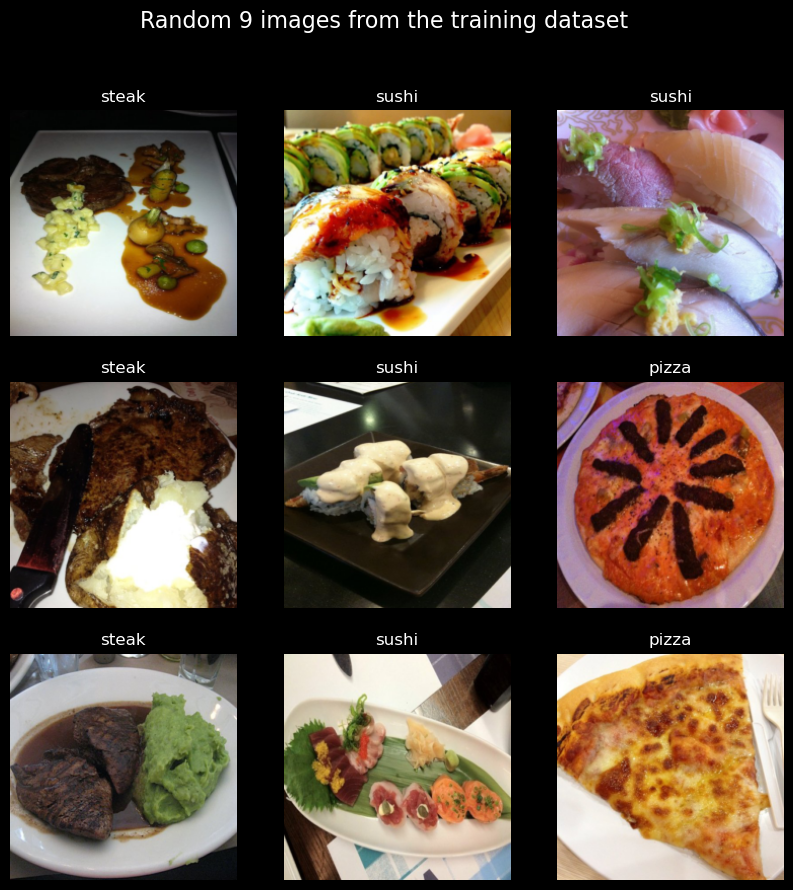

In [7]:
import matplotlib.pyplot as plt
import random

num_rows = 3
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(training_dataset))

        # Display the image in the subplot
        # print(training_dataset[image_index])
        axs[i, j].imshow(training_dataset[image_index][0].permute((1, 2, 0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(training_dataset.classes[training_dataset[image_index][1]], color="white")

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")

# Set the background color of the figure as black
fig.set_facecolor(color='black')

# Display the plot
plt.show()

In [8]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

#the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

In [9]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

torch.Size([32, 3, 224, 224])


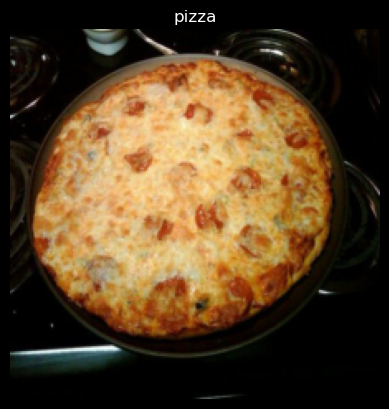

In [10]:
random_images, random_labels = next(iter(training_dataloader))
print(random_images.shape)
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

# Display the random image
plt.imshow(random_image.permute((1, 2, 0)))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(training_dataset.classes[random_labels[0]], color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")


In [11]:
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')
print(random_image.unsqueeze(0).shape)
print(image_through_conv.shape)
# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten


Shape of embeddings through the conv layer -> [1, 768, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
Shape of embeddings through the flatten layer -> [1, 196, 768] <- [batch_size, num_of_patches, embedding_dims]


In [12]:
class_token_embeddings = nn.Parameter(torch.rand((1, 1,EMBEDDING_DIMS), requires_grad  = True))
print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

Shape of class_token_embeddings --> [1, 1, 768] <-- [batch_size, 1, emdedding_dims]

Shape of image embeddings with class_token_embeddings --> [1, 197, 768] <-- [batch_size, num_of_patches+1, embeddiing_dims]

Shape of position_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]

Shape of final_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]


In [13]:
print(embedded_image.shape)

torch.Size([1, 196, 768])


In [14]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

In [15]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)
print(random_images.shape)
patch_embeddings = patch_embedding_layer(random_images)
patch_embeddings.shape

torch.Size([32, 3, 224, 224])


torch.Size([32, 197, 768])

In [16]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [32, 3, 224, 224]    [32, 197, 768]       175,872              True
├─Conv2d (conv_layer)                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Flatten (flatten_layer)                     [32, 14, 14, 768]    [32, 196, 768]       --                   --
Total params: 766,464
Trainable params: 766,464
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.70
Input size (MB): 19.27
Forward/backward pass size (MB): 38.54
Params size (MB): 2.36
Estimated Total Size (MB): 60.17

In [17]:
# multihead attention
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [18]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = EMBEDDING_DIMS,
                                                             num_heads = 12
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [19]:
summary(model=multihead_self_attention_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                      [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multiheadattention)                    --                   [1, 197, 768]        2,362,368            True
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 1.21
Params size (MB): 0.01
Estimated Total Size (MB): 1.82

In [20]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [30]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = EMBEDDING_DIMS,
                                           mlp_size = 303,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                           [1, 197, 768]        [1, 197, 768]        1,536                True
├─Sequential (mlp)                                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                                                 [1, 197, 768]        [1, 197, 303]        233,007              True
│    └─GELU (1)                                                   [1, 197, 303]        [1, 197, 303]        --                   --
│    └─Dropout (2)                                                [1, 197, 303]        [1, 197, 303]        --                   --
│    └─Linear (3)                                            

In [22]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

In [23]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 12)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [24]:
summary(model=transformer_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 197, 768]        2,362,368            True
├─MachineLearningPerceptronBlock (mlp_block)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [25]:
class ViT(nn.Module):
  def __init__(self, img_size = 224,
               in_channels = 3,
               patch_size = 16,
               embedding_dims = 768,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 1000):
    super().__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [26]:
vit = ViT(img_size = 224,
               in_channels = 3,
               patch_size = 16,
               embedding_dims = 768,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 1000
          )

In [27]:
summary(model=vit,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [32, 3, 224, 224]    [32, 197, 768]       175,872              True
│    └─Conv2d (conv_layer)                                   [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                               [32, 14, 14, 768]    [32, 196, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerBlock (0)                                  [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [32, 197, 768]       [32, 197, 76

In [28]:
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

# for epoch in range(100):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(training_dataloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs = inputs.cuda()
#         labels = labels.cuda()

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = vit(inputs)
#         # print(outputs.shape)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         print(loss)

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')